## In this notebook we will perform alglomerative clustering in a numerical dataset

In [1]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent

from sklearn.preprocessing import StandardScaler

import umap
import umap.plot as uplot

from funcs import plot_cluster_dendrogram, plot_silouethes_agglomer, cophenetic_corr

sns.set_theme()

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, e

### Load and preprocess the data

The car MPG (Miles Per Gallon) dataset, often known as the Auto MPG dataset, is a popular collection of data that was sourced from the 1970s and 1980s. It provides a detailed insight into various attributes of cars that were in the market during that period. 

Dataset contains following columns:

1. `mpg`: Stands for Miles Per Gallon. This measures the distance in miles that a car can travel per gallon of fuel.

2. `cylinders`: Indicates the number of cylinders in the car's engine. This can be related to the power output of the engine.

3. `displacement`: A measure of the total volume of all the cylinders in an engine, typically measured in cubic inches or cubic centimeters.

4. `horsepower`: The power output of the car's engine, typically measured in horsepower.

5. `weight`: The total weight of the car, typically measured in pounds.

6. `acceleration`: A measure of how quickly the car can increase its speed, typically represented in seconds to go from 0 to 60 miles per hour.

7. `model year`: The year when the car model was released, typically represented as a two-digit number from 70 to 82 (for 1970 to 1982).

8. `origin`: A categorical variable representing the region where the car was manufactured. This is usually represented as a number: 1 for America, 2 for Europe, and 3 for Asia.

9. `car name`: The full name of the car model, typically in the format of "Manufacturer Model" (e.g., "ford torino").

Citation :  Quinlan,R.. (1993). Auto MPG. UCI Machine Learning Repository. https://doi.org/10.24432/C5859H.



In [3]:
# Load car mpg dataset
car_df_path = 'auto-mpg.csv'
car_df = pd.read_csv(car_df_path)
car_df.shape

(398, 9)

In [4]:
# Preview
car_df.head()

mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino

In [5]:
# Check for missing values
car_df.isna().sum(axis=0)

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [6]:
# Preview column datatypes
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [7]:
car_df['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [8]:
# Remove missing values
car_df = car_df[car_df['horsepower'] != '?'].reset_index(drop=True)
car_df.shape

(392, 9)

In [9]:
# Get number of unique car names
car_df['car name'].nunique()

301

In [10]:
# Give unique name to each car by adding prefix (nth_occurence_car-name)
diversifier = car_df.groupby('car name').cumcount().to_numpy()
diversifier = ['' if val==0 else '_' + str(val) for val in diversifier]
diversifier = pd.Series(diversifier)
car_df['car name'] = car_df['car name'] + diversifier + '_' + car_df['model year'].astype(str)

# Set car name as index
car_df = car_df.set_index('car name', drop=True)

In [11]:
car_df

mpg  cylinders  displacement horsepower  \
car name                                                                 
chevrolet chevelle malibu_70  18.0          8         307.0        130   
buick skylark 320_70          15.0          8         350.0        165   
plymouth satellite_70         18.0          8         318.0        150   
amc rebel sst_70              16.0          8         304.0        150   
ford torino_70                17.0          8         302.0        140   
...                            ...        ...           ...        ...   
ford mustang gl_82            27.0          4         140.0         86   
vw pickup_82                  44.0          4          97.0         52   
dodge rampage_82              32.0          4         135.0         84   
ford ranger_82                28.0          4         120.0         79   
chevy s-10_82                 31.0          4         119.0         82   

                              weight  acceleration  model year  origin  
car name                                                                
chevrolet chevelle malibu_70    3504          12.0          70       1  
buick skylark 320_70            3693          11.5          70       1  
plymouth satellite_70           3436          11.0          70       1  
amc rebel sst_70                3433          12.0          70       1  
ford torino_70                  3449          10.5          70       1  
...                              ...           ...         ...     ...  
ford mustang gl_82              2790          15.6          82       1  
vw pickup_82                    2130          24.6          82       2  
dodge rampage_82                2295          11.6          82       1  
ford ranger_82                  2625          18.6          82       1  
chevy s-10_82                   2720          19.4          82       1  

[392 rows x 8 columns]

In [12]:
# Cast other columns to float
car_df = car_df.astype(np.float32)

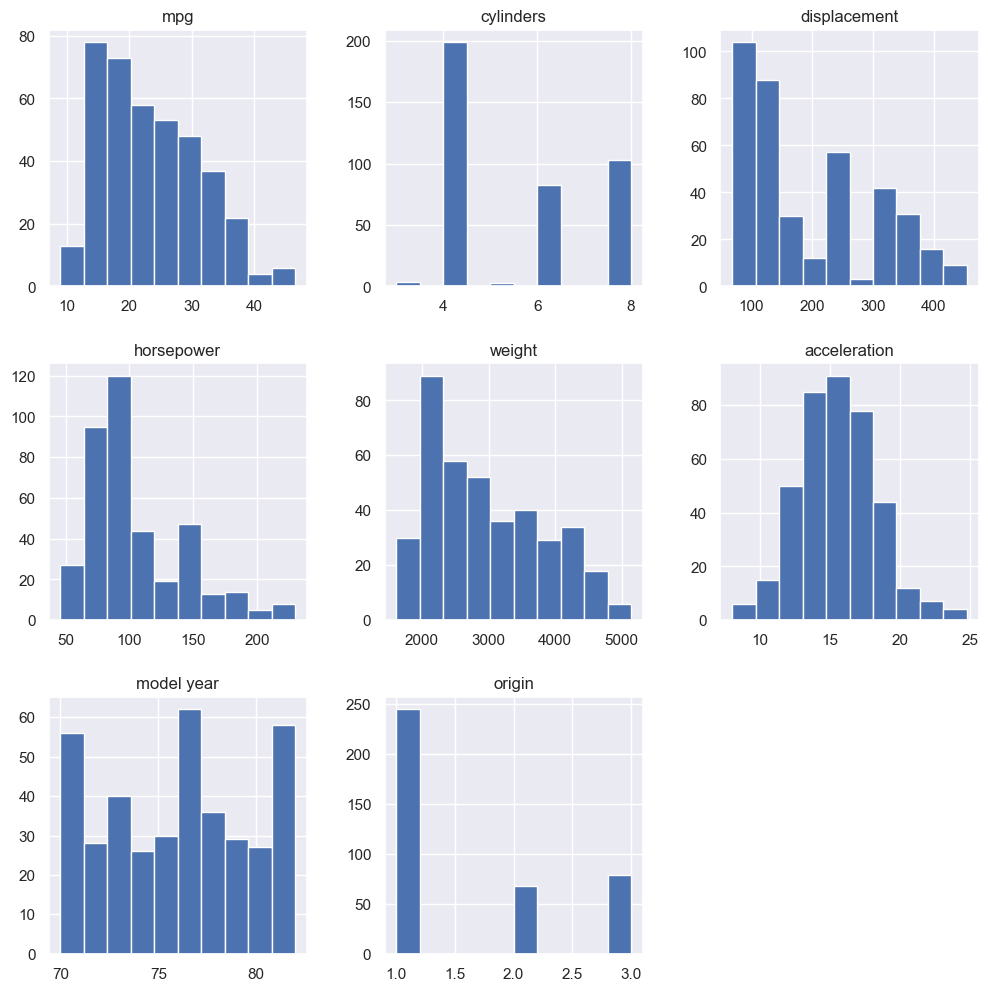

In [13]:
# Plot variable value distribution
_ = car_df.hist(figsize=(12,12))

In [14]:
# Remove origin column and save it as separate variable
origin = car_df['origin']

origin_mapping = {1: 'USA', 2: 'Europe', 3: 'Asia'}
origin = origin.map(origin_mapping)

In [15]:
# Make a copy of the dataframe for latter use
car_df_copy = car_df.copy()
car_df_copy['origin'] = origin

car_df = car_df.drop(columns=['origin'])


In [16]:
car_df

mpg  cylinders  displacement  horsepower  \
car name                                                                  
chevrolet chevelle malibu_70  18.0        8.0         307.0       130.0   
buick skylark 320_70          15.0        8.0         350.0       165.0   
plymouth satellite_70         18.0        8.0         318.0       150.0   
amc rebel sst_70              16.0        8.0         304.0       150.0   
ford torino_70                17.0        8.0         302.0       140.0   
...                            ...        ...           ...         ...   
ford mustang gl_82            27.0        4.0         140.0        86.0   
vw pickup_82                  44.0        4.0          97.0        52.0   
dodge rampage_82              32.0        4.0         135.0        84.0   
ford ranger_82                28.0        4.0         120.0        79.0   
chevy s-10_82                 31.0        4.0         119.0        82.0   

                              weight  acceleration  model year  
car name                                                        
chevrolet chevelle malibu_70  3504.0          12.0        70.0  
buick skylark 320_70          3693.0          11.5        70.0  
plymouth satellite_70         3436.0          11.0        70.0  
amc rebel sst_70              3433.0          12.0        70.0  
ford torino_70                3449.0          10.5        70.0  
...                              ...           ...         ...  
ford mustang gl_82            2790.0          15.6        82.0  
vw pickup_82                  2130.0          24.6        82.0  
dodge rampage_82              2295.0          11.6        82.0  
ford ranger_82                2625.0          18.6        82.0  
chevy s-10_82                 2720.0          19.4        82.0  

[392 rows x 7 columns]

In [17]:
# Scale the data
scaler = StandardScaler()
car_df[:] = scaler.fit_transform(car_df)

## Aglomerative clustering 


In [20]:
linkage_matrix = linkage(car_df.to_numpy(), method='ward')

In [21]:
cophenetic_corr(
    linkage_matrix=linkage_matrix,
    data_mtx = car_df.to_numpy()
)

Cophenetic correlation : 0.7682471079646638


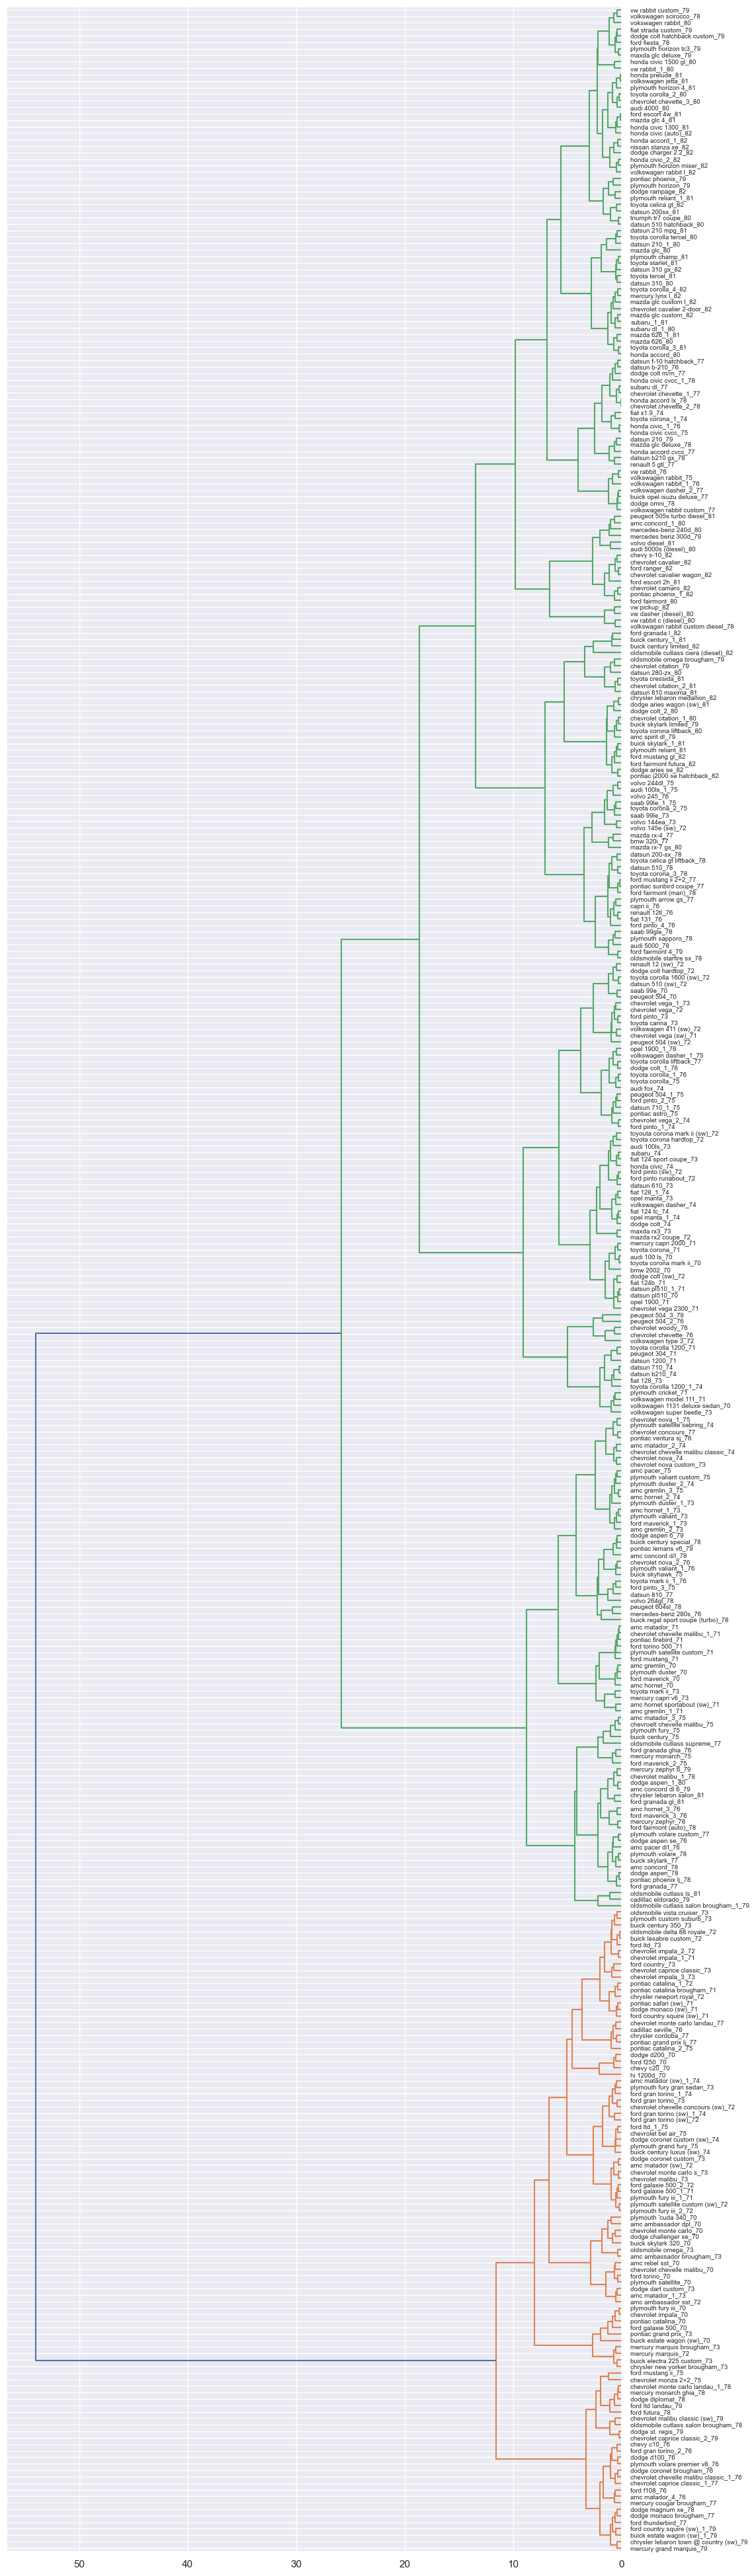

In [26]:
# Plot dendrogram and label it by car type
plt.rcParams['figure.figsize'] = [12, 50]
_ = dendrogram(
    linkage_matrix, 
    labels=car_df.index,
    orientation='left', 
    leaf_font_size=7
)

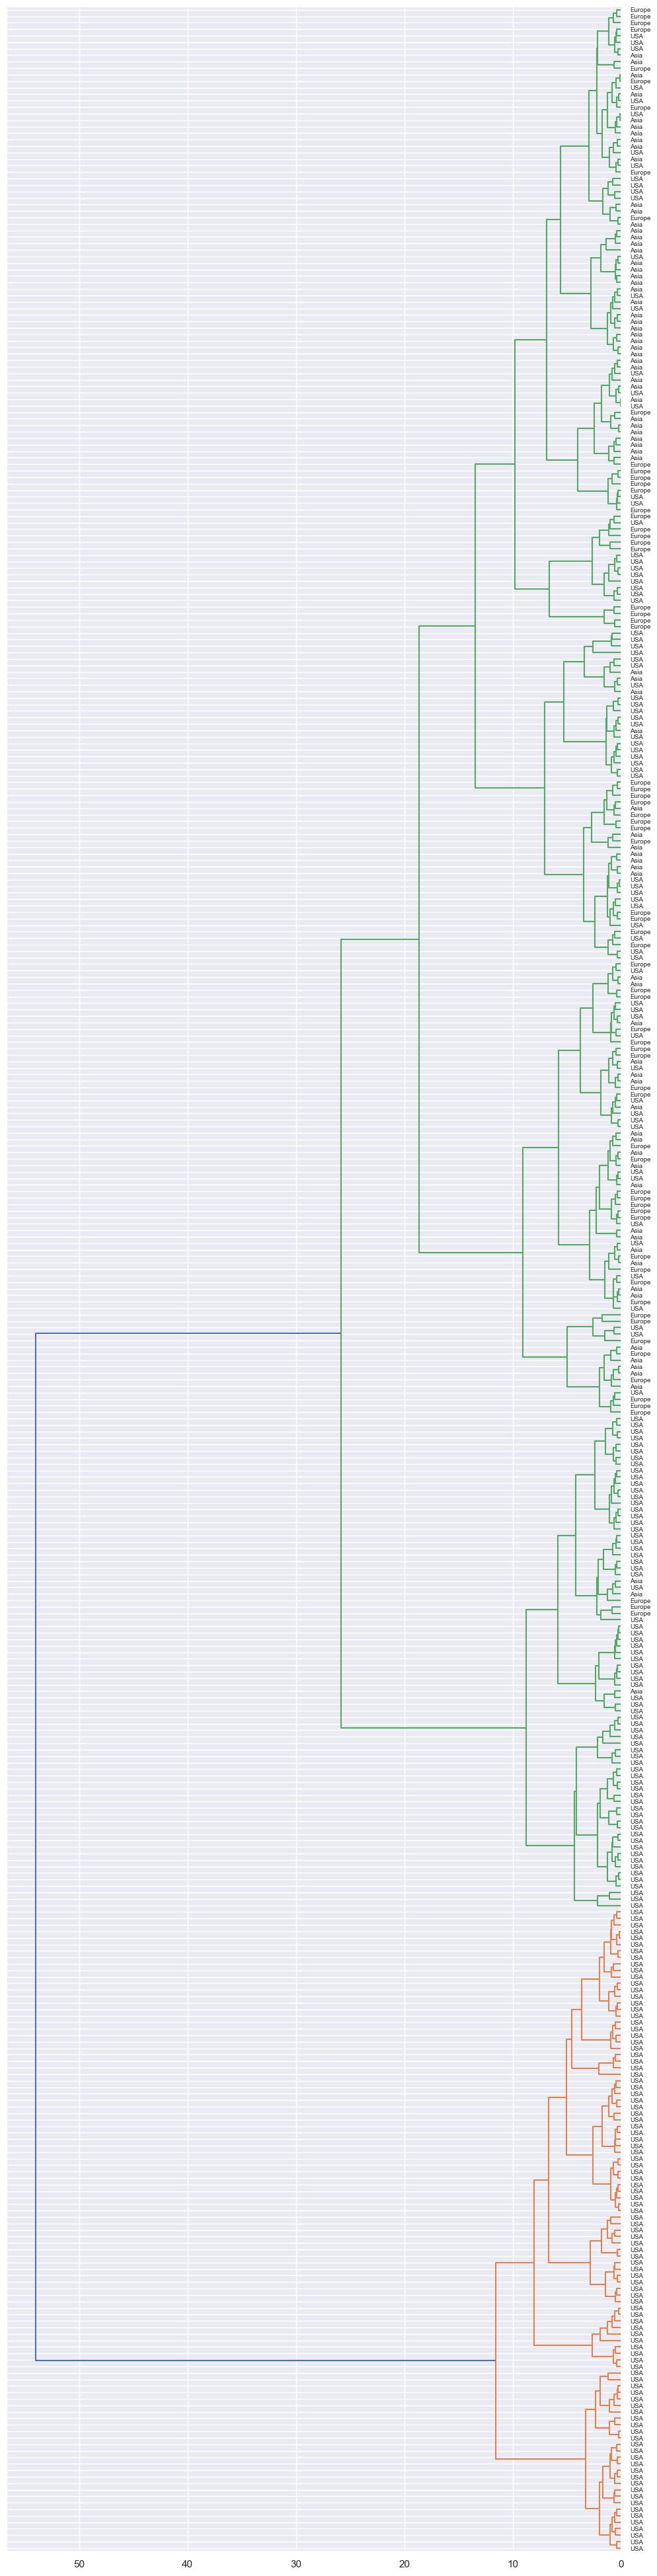

In [27]:
# Plot dendrogram and add country of origin
plt.rcParams['figure.figsize'] = [12, 50]
_ = dendrogram(
    linkage_matrix, 
    labels=origin.values,
    orientation='left',
    leaf_font_size=7
)

## Clustering using the height method 



/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/umap/plot.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

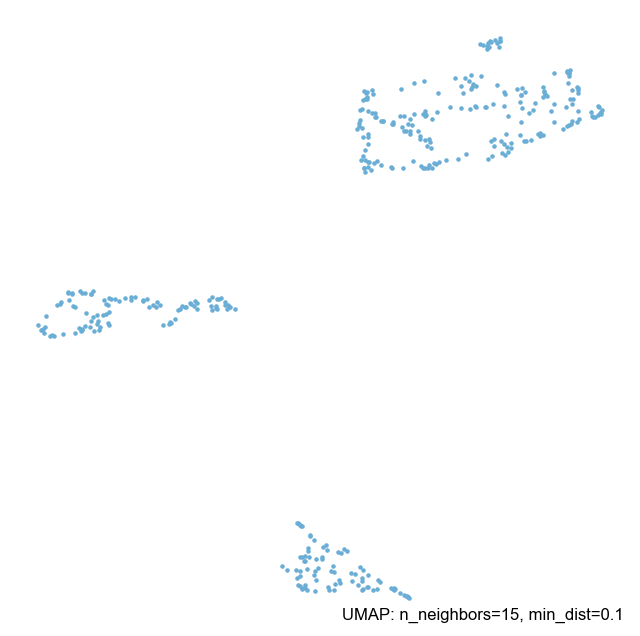

In [28]:
# Perfrom UMAP dimensionality reduction
umap_obj = umap.UMAP(n_neighbors=15)
embedding_mtx = umap_obj.fit_transform(car_df)

uplot.points(umap_obj)

<Axes: >

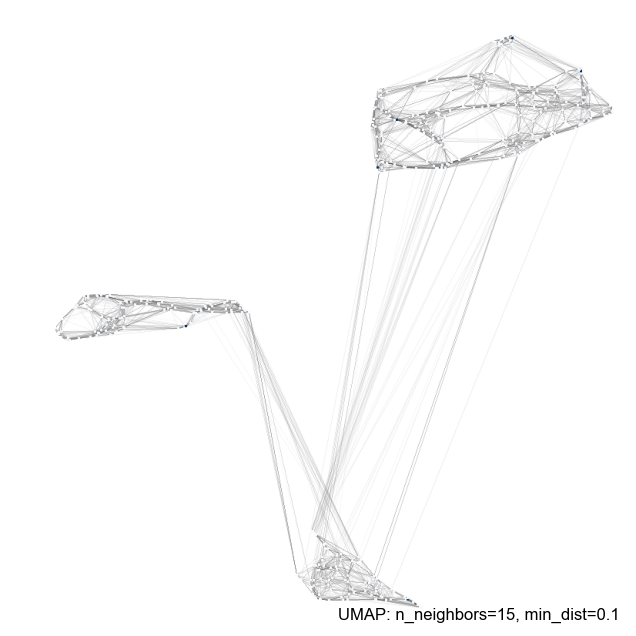

In [29]:
umap.plot.connectivity(umap_obj, show_points=True)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

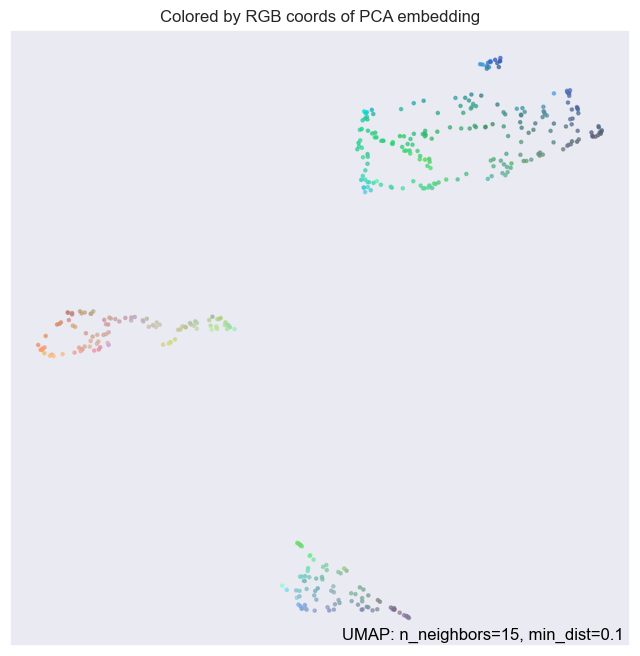

In [30]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
umap.plot.diagnostic(umap_obj, diagnostic_type='pca',ax=ax)

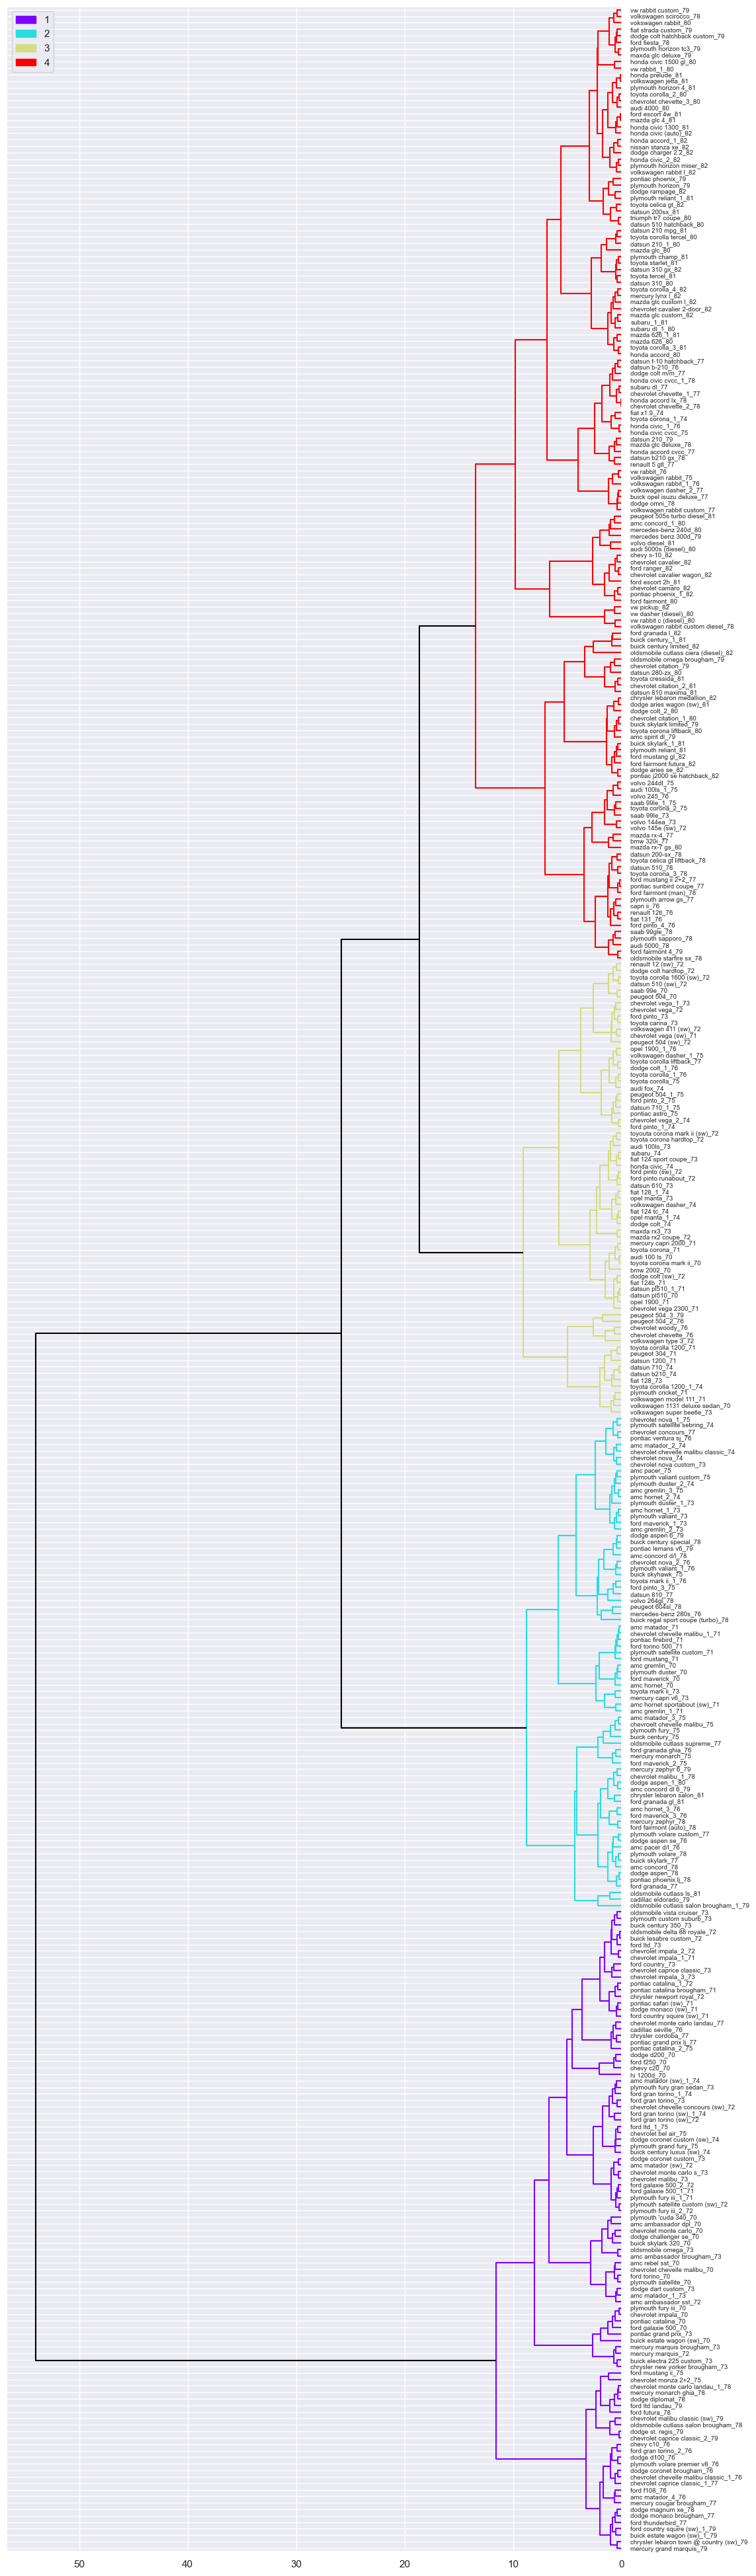

In [31]:
# Perform clustering based on height
clusters = fcluster(
    Z=linkage_matrix,
    t=18, 
    criterion='distance',
)

dendr_colors = plot_cluster_dendrogram(
    linkage_matrix=linkage_matrix,
    dataset_df=car_df,
    clusters=clusters,
    leaf_font_size=7
)

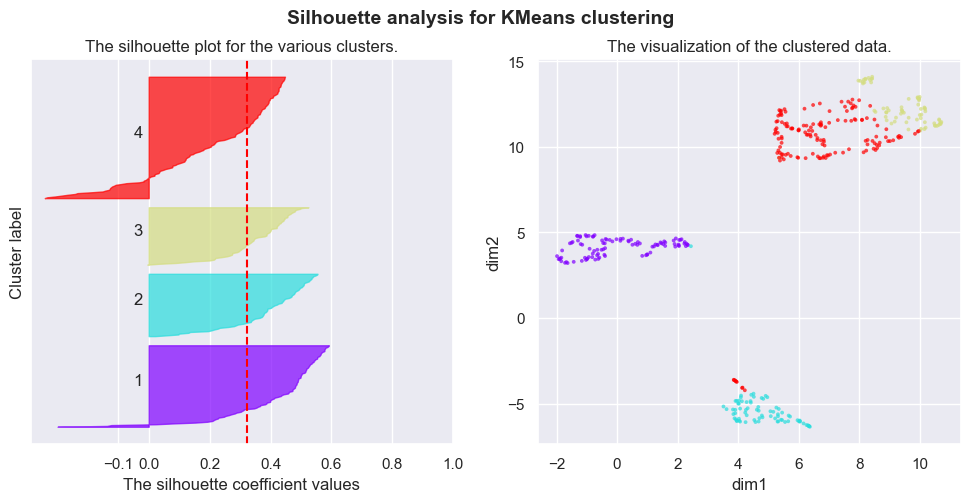

In [32]:
_ = plot_silouethes_agglomer(
    data_df=car_df,
    clusters=clusters,
    dendr_colors=dendr_colors,
    embedding_mtx=embedding_mtx
)

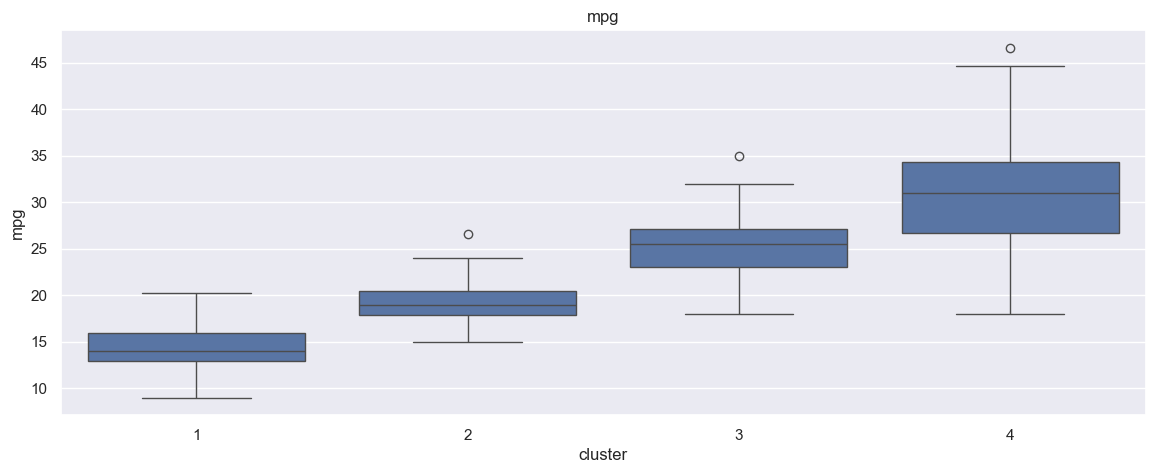

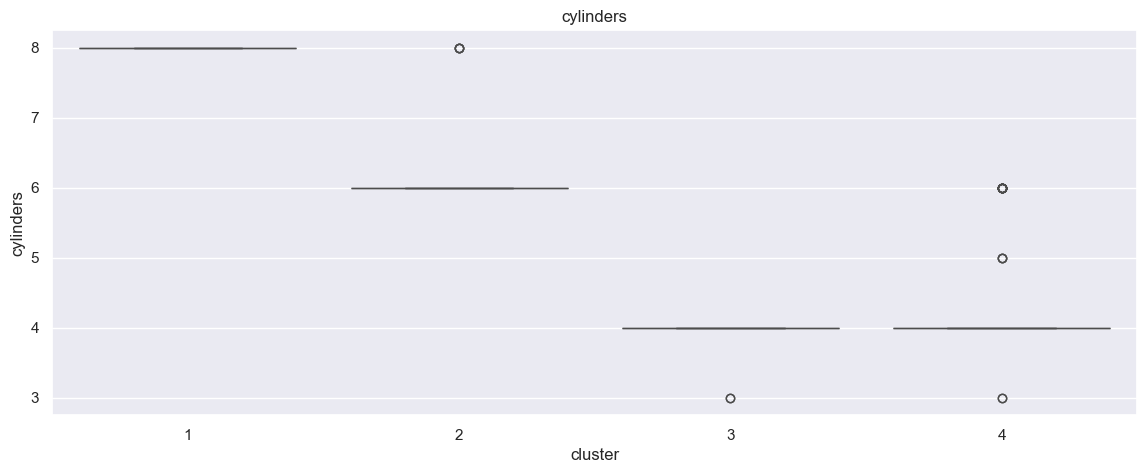

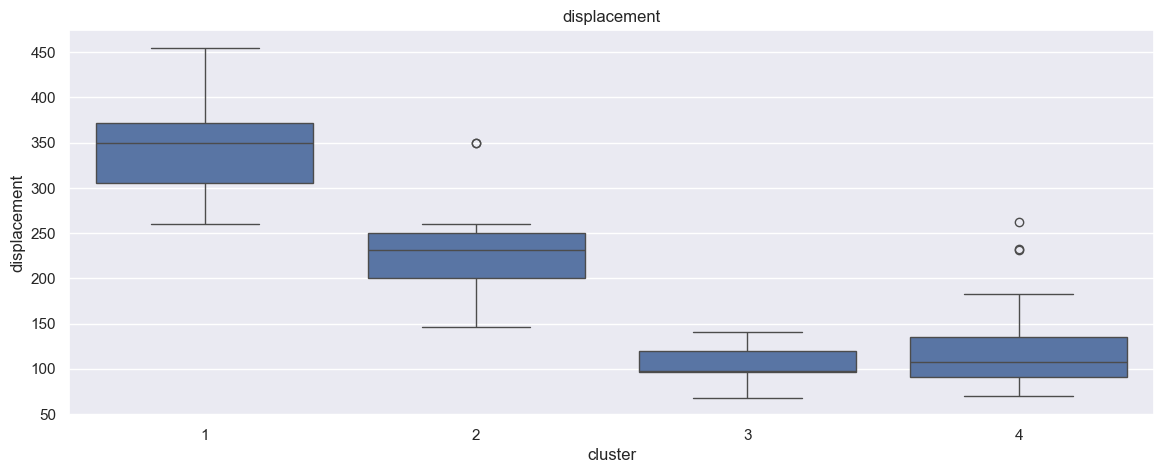

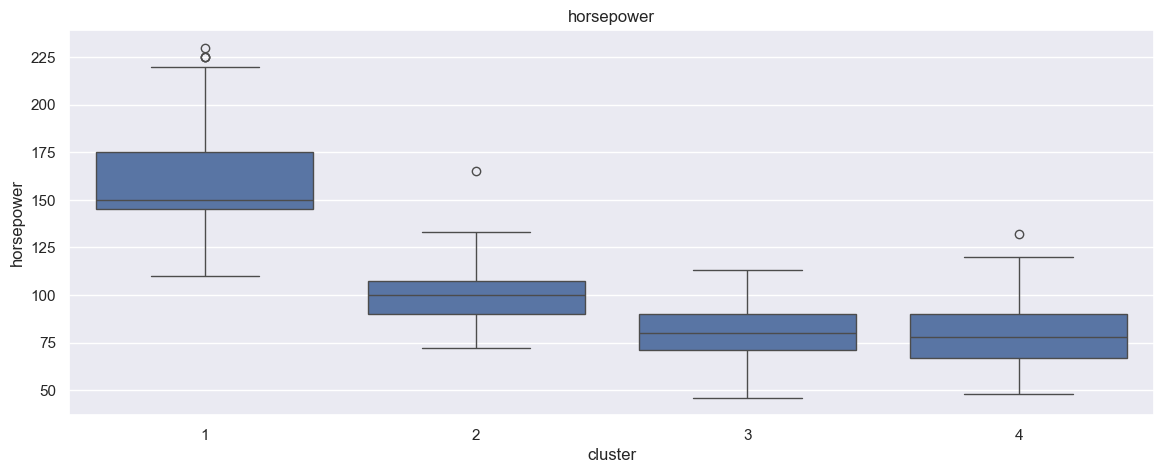

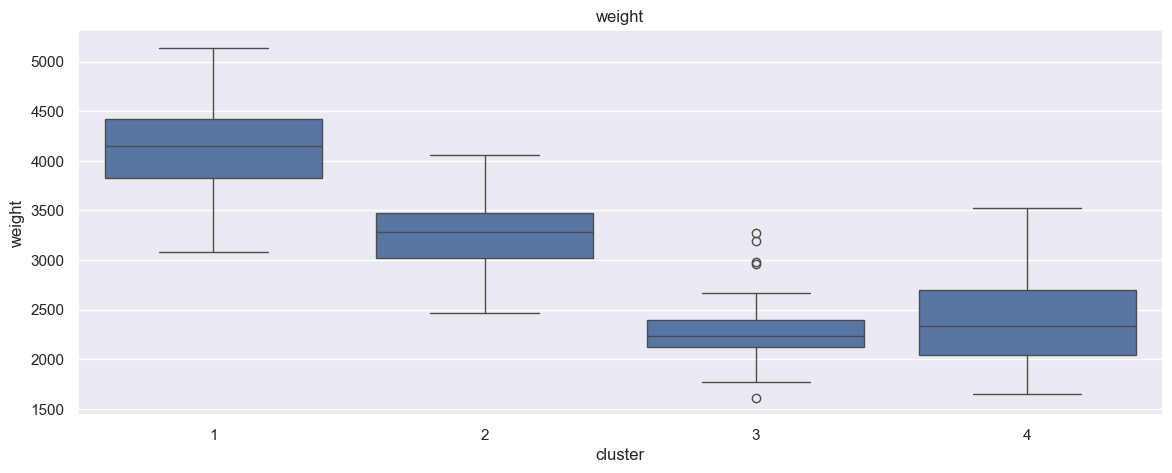

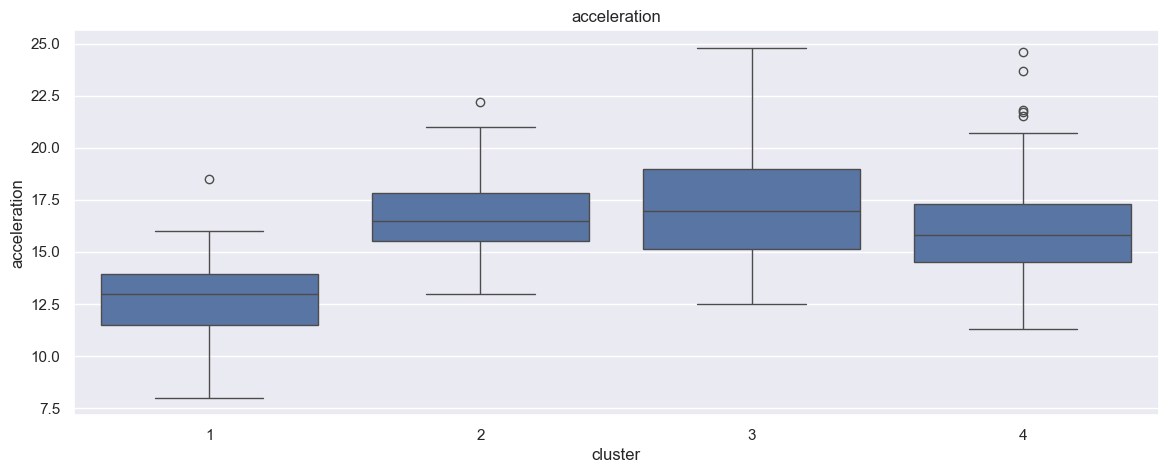

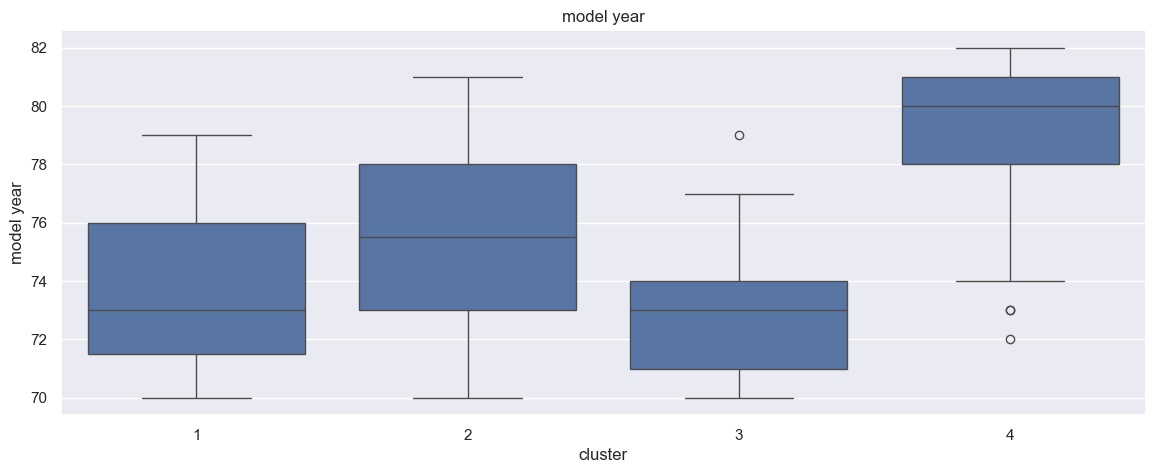

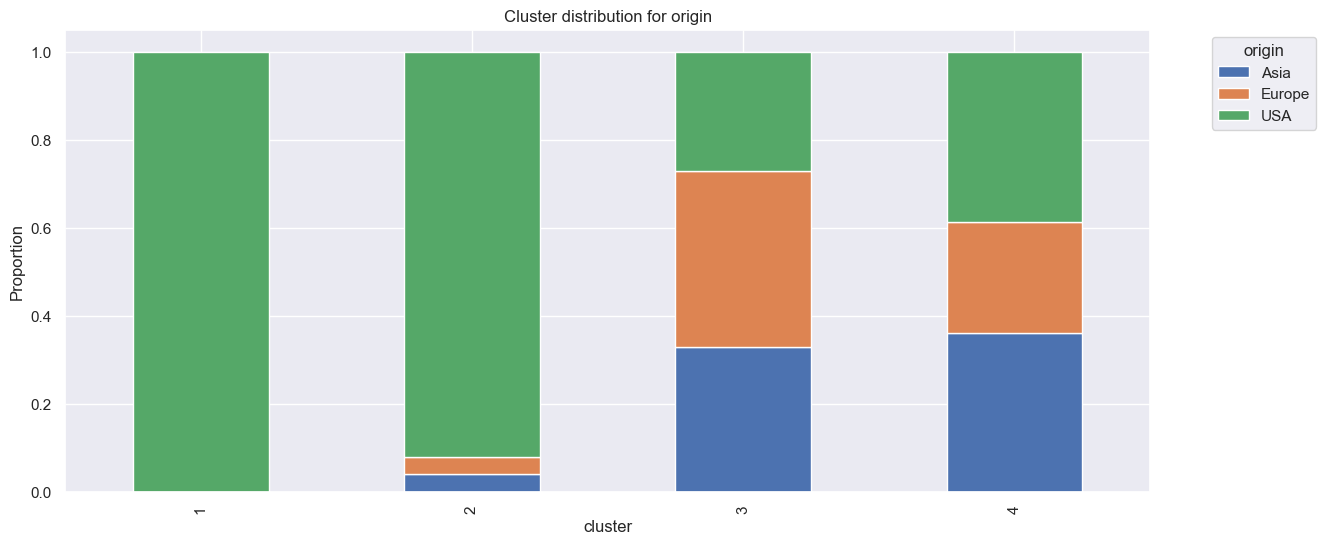

In [33]:
car_df_copy['cluster'] = clusters
numeric_col_names = car_df_copy.select_dtypes(include=[np.number]).columns.tolist()

# Plot features
for feature in car_df_copy.columns:
    
    if feature != 'cluster':
    
        if feature in numeric_col_names:
            
            plt.figure(figsize=(14,5))
            sns.boxplot(car_df_copy, x='cluster', y=feature)
            plt.title(feature)
            
        else:
            
            proportions = car_df_copy.groupby(
                'cluster'
            )[feature].value_counts(
                normalize=True
            ).unstack()
            
            
                    
            # Create stacked bar plot
            ax = proportions.plot(kind='bar', stacked=True, figsize=(14, 6))
            plt.title(f'Cluster distribution for {feature}')
            plt.ylabel('Proportion')

            # Add legend
            plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')

            # Get category labels
            category_labels = proportions.columns.tolist()[::-1]
            plt.show()

## Clustering using inconsistency method 

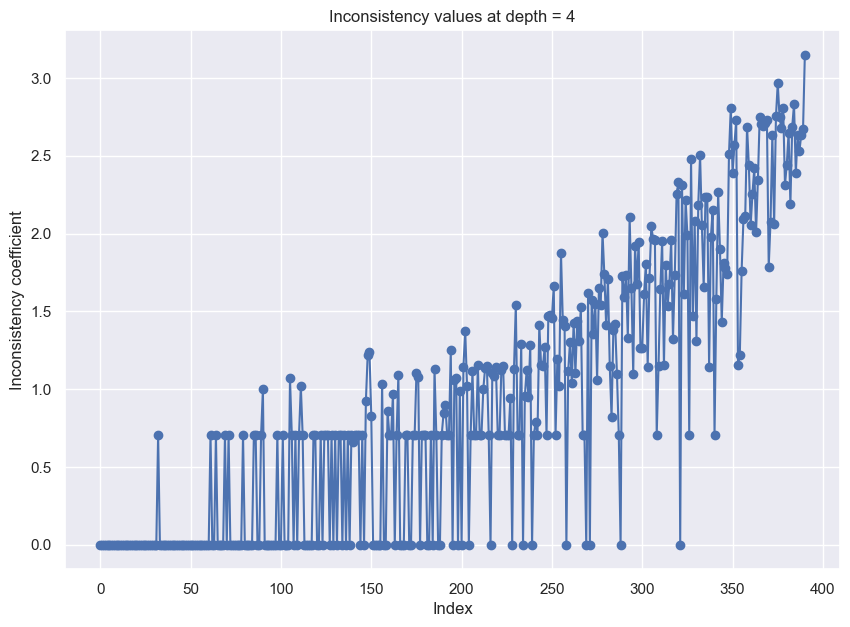

In [34]:
# Calculate inconsistence matrix
depth=4
incosistent_mtx = inconsistent(linkage_matrix,depth)

# Plot inconsistency scores for given depth
plt.figure(figsize=(10, 7))
plt.plot(incosistent_mtx[:,-1])
plt.scatter(range(incosistent_mtx.shape[0]),incosistent_mtx[:,-1])
plt.title('Inconsistency values at depth = {}'.format(depth))
plt.xlabel('Index')
plt.ylabel('Inconsistency coefficient')
plt.show()

In [35]:
# Perform clustering based on inconsistency
# and print clusters
clusters = fcluster(Z=linkage_matrix, t=2.7, criterion='inconsistent', R=incosistent_mtx)
clusters

array([ 3,  3,  3,  3,  3,  2,  2,  2,  2,  3,  3,  3,  3,  2, 17, 12, 12,
       12, 17, 16, 19, 17, 19, 17, 12,  6,  6,  6,  6, 17, 17, 17, 12, 12,
       12, 12, 12,  8,  8,  4,  4,  8,  8,  8, 12, 19, 12, 12, 17, 17, 16,
       17, 16, 16, 16, 16, 17, 19, 16, 19, 17,  8,  8,  4,  4,  3,  2,  8,
        8,  8, 17,  4,  5,  5,  4, 20, 19, 19, 19, 17, 19, 17, 17, 19,  8,
        3,  4,  5,  4,  2,  8,  8,  5,  2,  2,  3, 14, 15, 14, 14, 14, 16,
        8,  8,  8,  8, 14, 19, 19, 17, 17, 19, 12, 17,  4,  2, 16, 17, 17,
       20,  3, 20, 12,  3, 14, 14, 15, 16, 18, 16, 18, 15, 15, 15,  5,  5,
        5,  5,  5, 18, 17, 17, 25, 16, 17, 17, 17, 17, 17, 25, 14, 15, 11,
       11,  7,  5,  5,  5, 11, 11, 11, 11, 13,  1,  1, 18, 18, 14, 18, 20,
       18, 18, 13, 25, 14, 20, 18, 20, 20, 25, 20, 18, 20, 18, 20,  1,  1,
        1,  1, 13, 13, 10, 10, 16, 16, 25, 25, 10, 11, 15, 10, 25, 25, 18,
       20, 20,  1, 16, 13, 13,  7,  1,  1,  1, 25, 25, 25, 20, 25,  1, 11,
        1,  1, 15, 10, 10

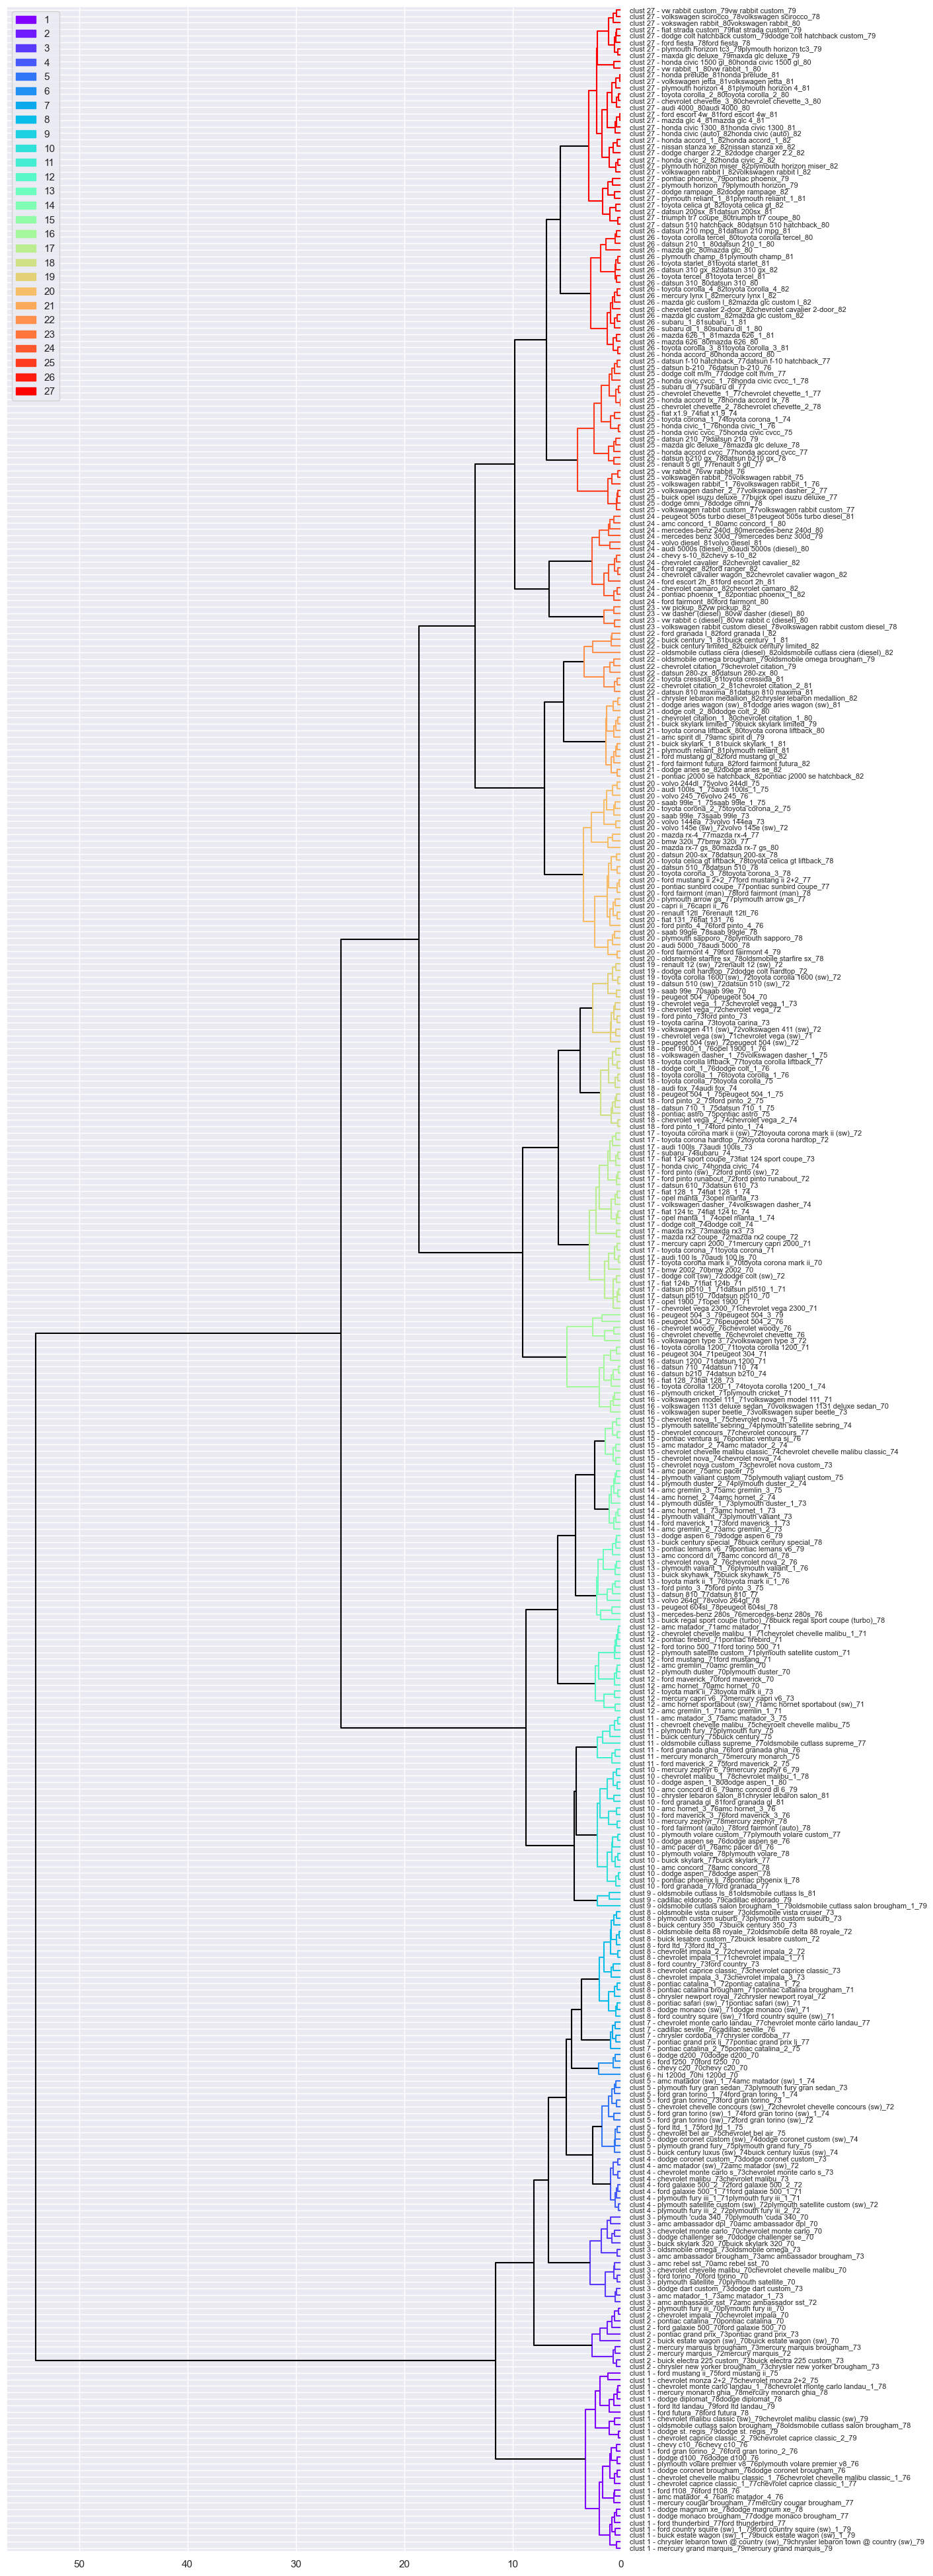

In [36]:
label_list = ['clust {} - {}'.format(clust, name) + name for name, clust in zip(car_df.index, clusters)]

dendr_colors = plot_cluster_dendrogram(
    linkage_matrix=linkage_matrix,
    dataset_df=car_df,
    clusters=clusters,
    leaf_font_size=8,
    labels=label_list
)

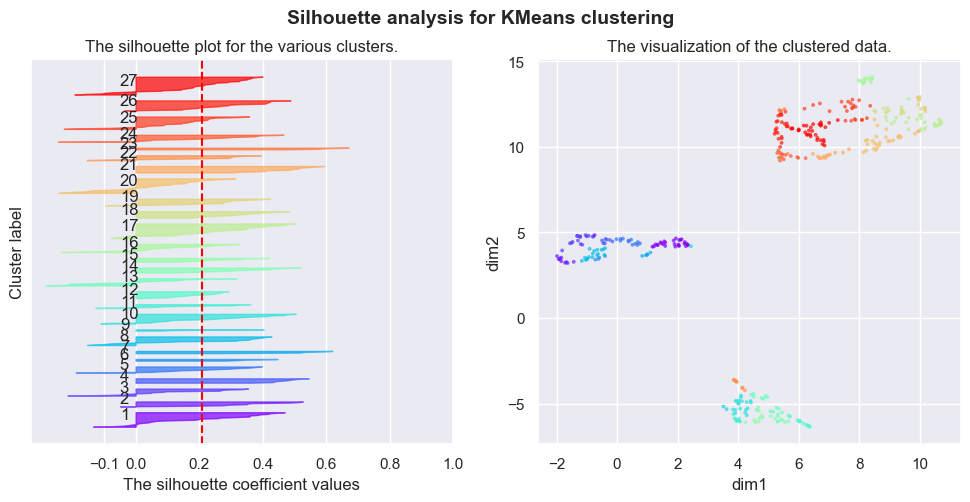

In [37]:
_ = plot_silouethes_agglomer(
    data_df=car_df,
    clusters=clusters,
    dendr_colors=dendr_colors,
    embedding_mtx=embedding_mtx
)

## Cluster characterization 

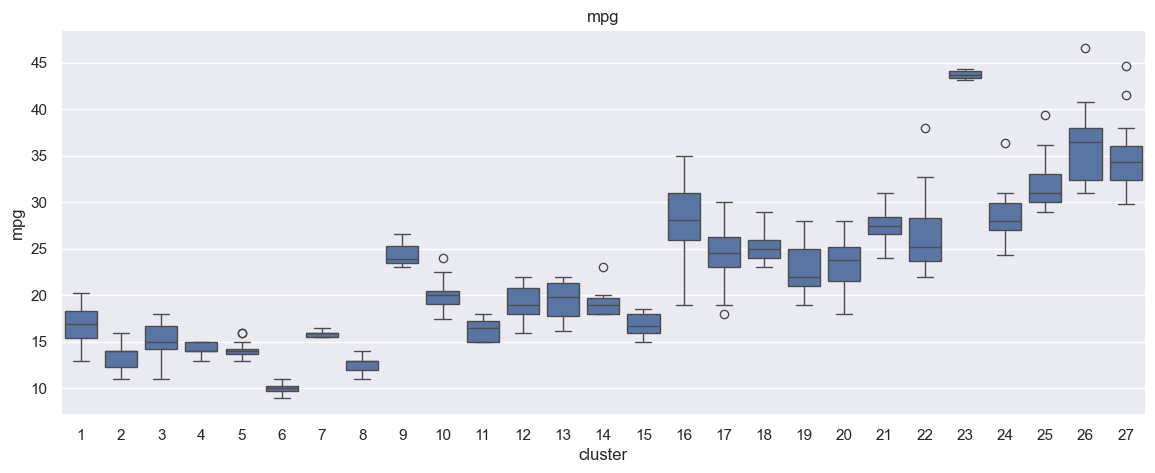

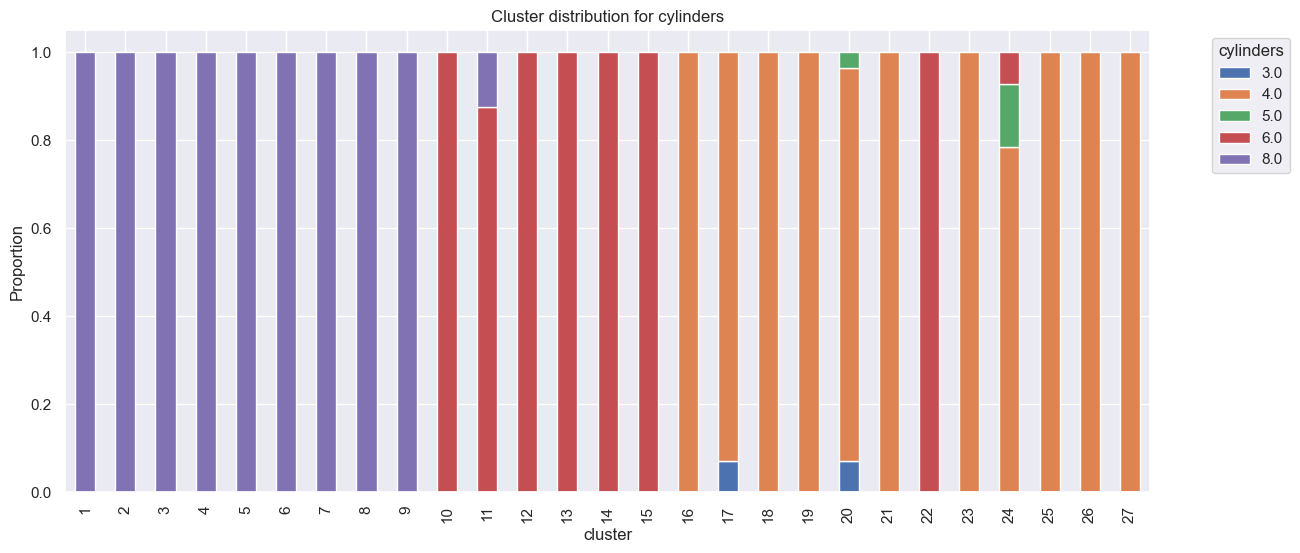

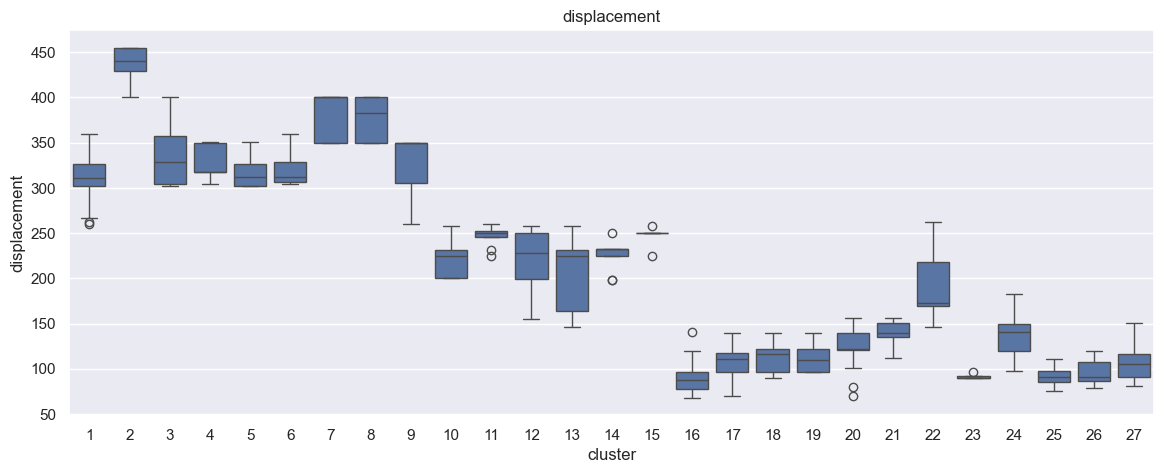

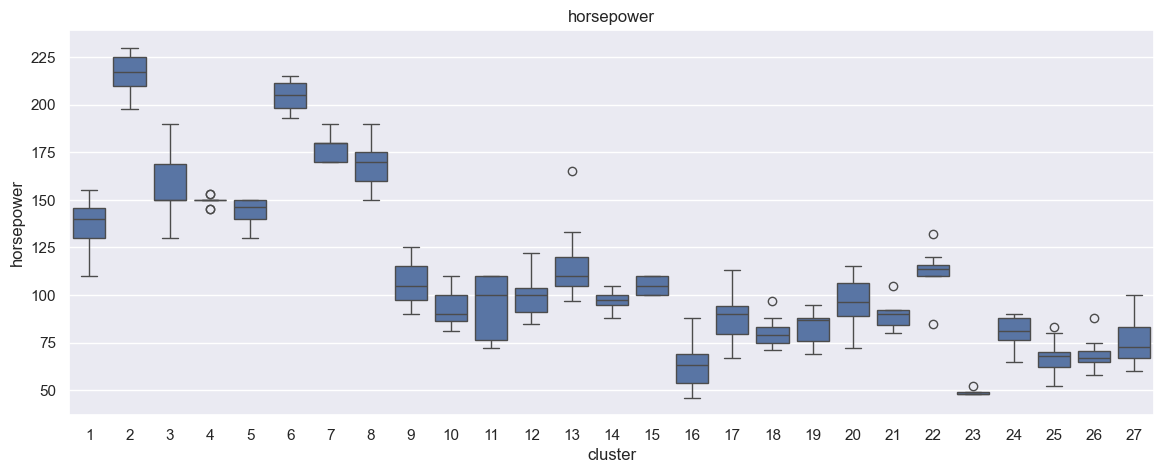

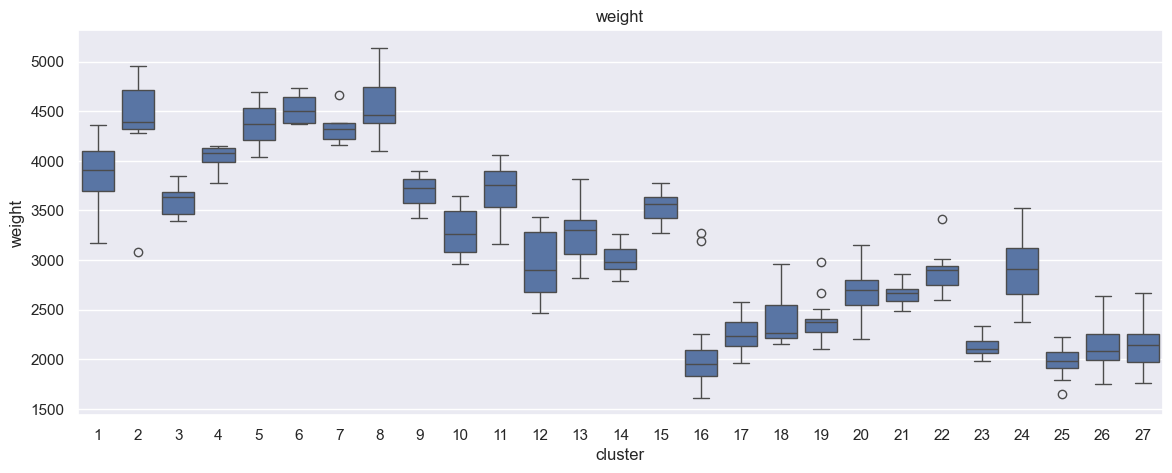

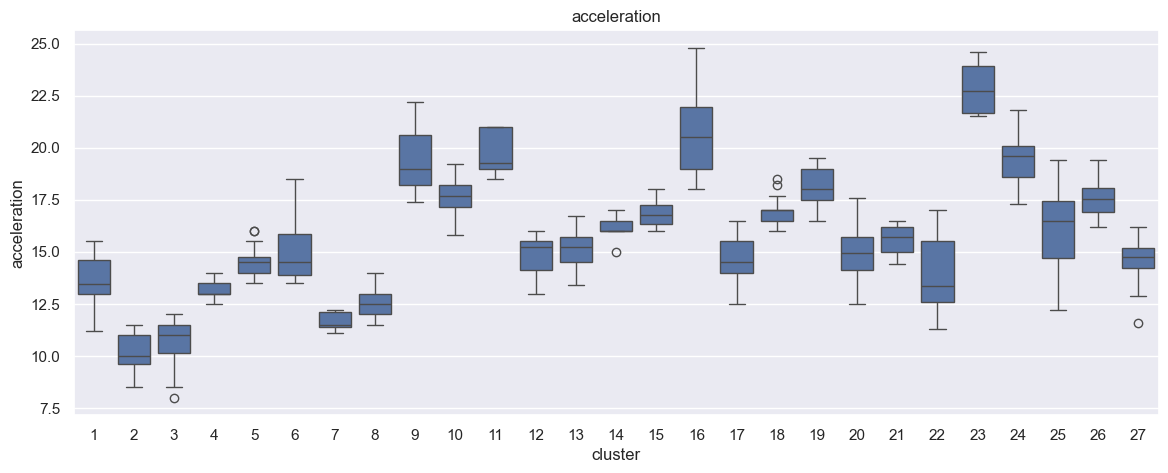

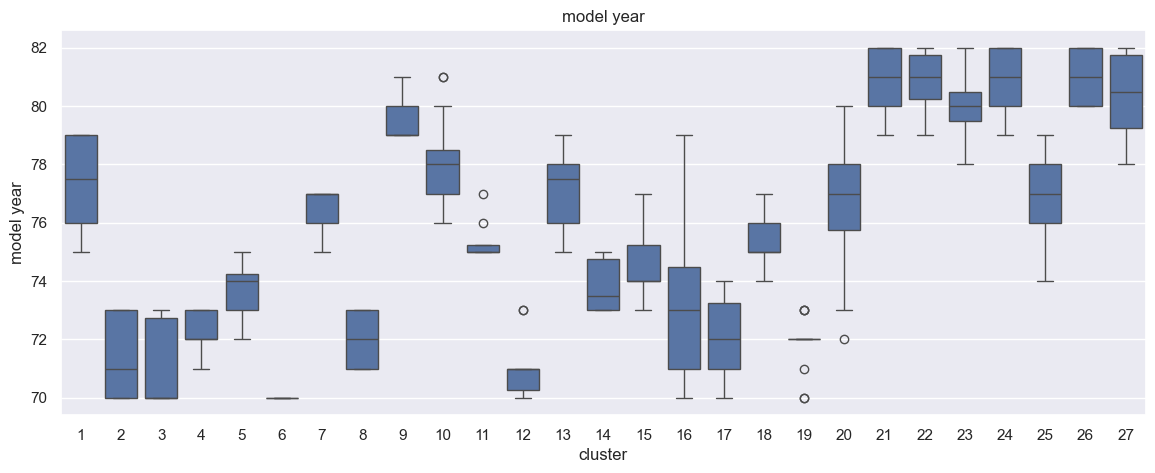

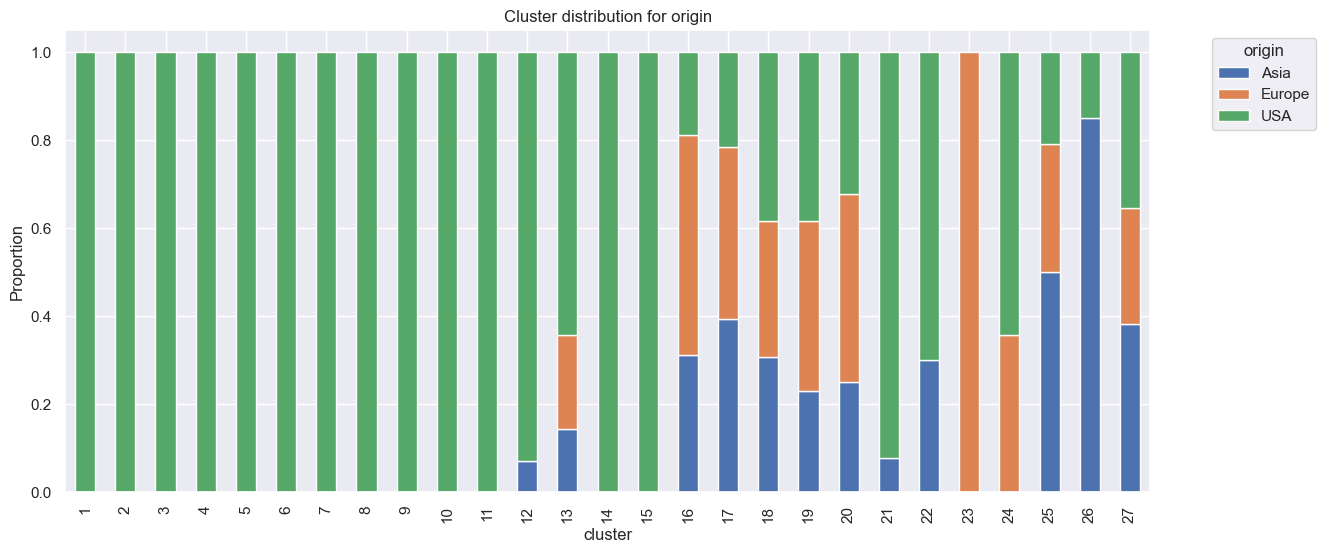

In [38]:
car_df_copy['cluster'] = clusters
car_df_copy['cylinders'] = car_df_copy['cylinders'].astype(object)
numeric_col_names = car_df_copy.select_dtypes(include=[np.number]).columns.tolist()

# Plot features
for feature in car_df_copy.columns:
    
    if feature != 'cluster':
    
        if feature in numeric_col_names:
            
            plt.figure(figsize=(14,5))
            sns.boxplot(car_df_copy, x='cluster', y=feature)
            plt.title(feature)
            
        else:
            
            proportions = car_df_copy.groupby(
                'cluster'
            )[feature].value_counts(
                normalize=True
            ).unstack()
            
            
                    
            # Create stacked bar plot
            ax = proportions.plot(kind='bar', stacked=True, figsize=(14, 6))
            plt.title(f'Cluster distribution for {feature}')
            plt.ylabel('Proportion')

            # Add legend
            plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')

            # Get category labels
            category_labels = proportions.columns.tolist()[::-1]
            plt.show()

In [39]:
car_df_copy[car_df_copy['cluster']==23]

mpg cylinders  displacement  \
car name                                                                
volkswagen rabbit custom diesel_78  43.099998       4.0          90.0   
vw rabbit c (diesel)_80             44.299999       4.0          90.0   
vw dasher (diesel)_80               43.400002       4.0          90.0   
vw pickup_82                        44.000000       4.0          97.0   

                                    horsepower  weight  acceleration  \
car name                                                               
volkswagen rabbit custom diesel_78        48.0  1985.0     21.500000   
vw rabbit c (diesel)_80                   48.0  2085.0     21.700001   
vw dasher (diesel)_80                     48.0  2335.0     23.700001   
vw pickup_82                              52.0  2130.0     24.600000   

                                    model year  origin  cluster  
car name                                                         
volkswagen rabbit custom diesel_78        78.0  Europe       23  
vw rabbit c (diesel)_80                   80.0  Europe       23  
vw dasher (diesel)_80                     80.0  Europe       23  
vw pickup_82                              82.0  Europe       23

In [40]:
car_df_copy[car_df_copy['cluster']==2]

mpg cylinders  displacement  horsepower  \
car name                                                                    
ford galaxie 500_70              15.0       8.0         429.0       198.0   
chevrolet impala_70              14.0       8.0         454.0       220.0   
plymouth fury iii_70             14.0       8.0         440.0       215.0   
pontiac catalina_70              14.0       8.0         455.0       225.0   
buick estate wagon (sw)_70       14.0       8.0         455.0       225.0   
mercury marquis_72               11.0       8.0         429.0       208.0   
mercury marquis brougham_73      12.0       8.0         429.0       198.0   
chrysler new yorker brougham_73  13.0       8.0         440.0       215.0   
buick electra 225 custom_73      12.0       8.0         455.0       225.0   
pontiac grand prix_73            16.0       8.0         400.0       230.0   

                                 weight  acceleration  model year origin  \
car name                                                                   
ford galaxie 500_70              4341.0          10.0        70.0    USA   
chevrolet impala_70              4354.0           9.0        70.0    USA   
plymouth fury iii_70             4312.0           8.5        70.0    USA   
pontiac catalina_70              4425.0          10.0        70.0    USA   
buick estate wagon (sw)_70       3086.0          10.0        70.0    USA   
mercury marquis_72               4633.0          11.0        72.0    USA   
mercury marquis brougham_73      4952.0          11.5        73.0    USA   
chrysler new yorker brougham_73  4735.0          11.0        73.0    USA   
buick electra 225 custom_73      4951.0          11.0        73.0    USA   
pontiac grand prix_73            4278.0           9.5        73.0    USA   

                                 cluster  
car name                                  
ford galaxie 500_70                    2  
chevrolet impala_70                    2  
plymouth fury iii_70                   2  
pontiac catalina_70                    2  
buick estate wagon (sw)_70             2  
mercury marquis_72                     2  
mercury marquis brougham_73            2  
chrysler new yorker brougham_73        2  
buick electra 225 custom_73            2  
pontiac grand prix_73                  2